<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [72]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [73]:
from scipy.stats import bernoulli, beta             

In [74]:
import warnings
warnings.simplefilter('ignore')

In [75]:
%pwd

'/Users/danigomezlechonbarrachina/Desktop/Labs/6.4_lab-AB-Testing'

In [76]:
# datos
datos_csv=pd.read_csv("data/cookie_cats.csv")
datos_csv.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [77]:
# transformacion

control=datos_csv[datos_csv.version=="gate_30"]
test=datos_csv[datos_csv.version=="gate_40"]

Primero queremos saber el número total de veces de jugadores que han entrado en el juego y los que han tenido retención  (es decir, impresiones y conversiones)

In [78]:
imps_ctrl=control["retention_1"].count()
imps_test=test["retention_1"].count()

convs_ctrl=control["retention_1"][control["retention_1"]==True].count()
convs_test=test["retention_1"][test["retention_1"]==True].count()


In [79]:
imps_ctrl, imps_test,convs_ctrl,convs_test

(44700, 45489, 20034, 20119)

In [80]:
# testeo para retention_1
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)




In [81]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [82]:
x=np.linspace(0.4, 0.5, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

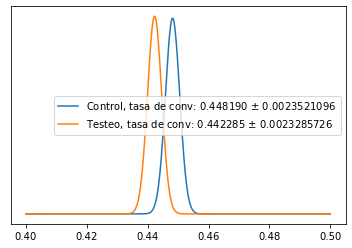

In [83]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [85]:
salto=(beta_control.mean()-beta_test.mean())/beta_test.mean()

salto

0.01335099887899125

In [86]:
!pip install mpmath

     |████████████████████████████████| 532 kB 2.2 MB/s eta 0:00:01


In [87]:
from mpmath import betainc   # integral de beta

prob=betainc(a_T, b_T, 0.0022, 1, regularized=True)

prob=float(prob)

prob

1.0



En el caso de la retention_1, es mejor la versión de control que la nueva versión. A pesar de ser muy parecidas podemos decir que es un 1.3% mejor de media que la nueva versión en un 100% de los casos

In [88]:
# testeo para retention_7

imps_ctrl=control["retention_7"].count()
imps_test=test["retention_7"].count()

convs_ctrl=control["retention_7"][control["retention_7"]==True].count()
convs_test=test["retention_7"][test["retention_7"]==True].count()



In [89]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)




In [90]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

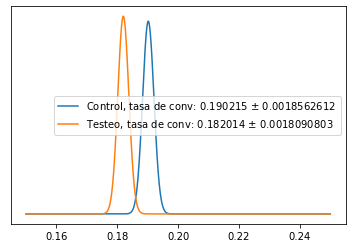

In [92]:
x=np.linspace(0.15, 0.25, 1000)

plot([beta_control, beta_test], ['Control', 'Testeo'])

In [93]:
salto=(beta_control.mean()-beta_test.mean())/beta_test.mean()

salto

0.04505794626660234

In [94]:
from mpmath import betainc   # integral de beta

prob=betainc(a_T, b_T, 0.0022, 1, regularized=True)

prob=float(prob)

prob

1.0

En el caso de la retention_7, es mejor la versión de control que la nueva versión. A pesar de ser muy parecidas podemos decir que es un 4.5% mejor de media que la nueva versión en un 100% de los casos